# 1. What are the top courses in Udemy?
First, I would like to know what are the top courses in Udemy? For this, I will use the `avg_rating` (average rating) and `num_reviews` (number of reviews) for each course and based on an exponential average smoothing I will try to select the best courses. I will be using this approach because both `avg_rating` and the `num_reviews` are highly related to each other. For example, if a course has a rating of 4 and 10 reviews, and another course has a rating of 5 and 1 review, it will be unfair to say that the second course is "better" than the first course. This is why an exponential average smoothing will help to solve this issue.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Course_info.csv')

In [3]:
df = data[['id', 'title', 'avg_rating', 'num_reviews', 'language']].copy()

## 1.1 Look at the Distribution
We will plot the course ratings vs. the number of reviews to see the relevance of having more reviews against the rating of a course.

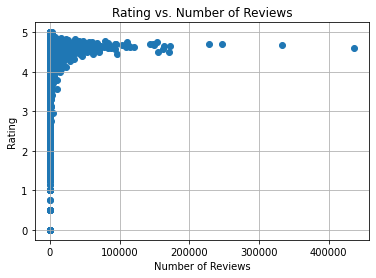

In [4]:
plt.scatter(df['num_reviews'], df['avg_rating'])
plt.ylabel('Rating')
plt.xlabel('Number of Reviews')
plt.title('Rating vs. Number of Reviews')
plt.grid('on')
plt.show()

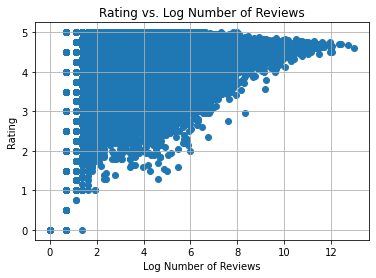

In [5]:
plt.scatter(np.log1p(df['num_reviews']), df['avg_rating'])
plt.ylabel('Rating')
plt.xlabel('Log Number of Reviews')
plt.title('Rating vs. Log Number of Reviews')
plt.grid('on')
plt.show()

It is interesting to note that as the number of reviews increases, the rating of a course will go from a high value (like 5) to a smaller value (like 4.5). This makes sense due the fact that the rating is an average of all the ratings of the reviewers. Again, this only reinforces my initial idea that an exponential average will help. To better visualize the effect of the number of reviews on the rating a second plot with a log scale on the number of reviews is provided.

## 1.2 Exponential Smoothing
For the exponential smoothing a similar solution as the one provided in [here](https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score) is created. The main idea is to create a mapping function that uses the `num_reviews` as a exponential weight factor that increases the `avg_rating`. Therefore, if the `num_reviews` is higher, the `avg_rating` will increase considerable, on the other hand, if `num_reviews` is lower, the effect on `avg_rating` will be smaller.

To do so a `score_calc` function is created, with the parameters described in its documentation.

In [6]:
def score_calc(p, q, P=0.5, Q=144):
    """
    Scoring function using a weighted exponential score for 
    the average rating and number of ratings provided.
    
    Parameters
    ----------
    p : float
        Average rating
    q : int
        Number of ratings
    P : float
        Weight assigned to average rating
    Q : float
        Number that defines how much the ratings affect the score
    
    
    Returns
    -------
    float
        a weighted exponential score for the average rating and 
        number of ratings provided.
    """
    return P*p + 5*(1-P)*(1-np.exp(-q/Q))

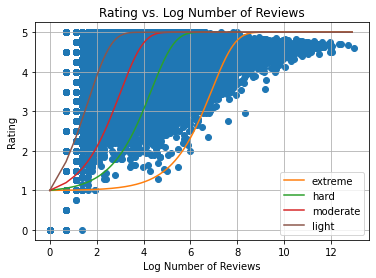

In [7]:
t = 400000
q = np.linspace(0,t,t)
#Q = np.array([10000, 1000, 75, 250])
Q = np.array([1000, 75, 20, 5])
# We can find Q as -M/ln(0.5)
#Q = np.round(1.44*M)


plt.plot(np.log1p(q), score_calc(5, q, Q=Q[0], P=0.2), label='extreme', color='C1')
plt.plot(np.log1p(q), score_calc(5, q, Q=Q[1], P=0.2), label='hard', color='C2')
plt.plot(np.log1p(q), score_calc(5, q, Q=Q[2], P=0.2), label='moderate', color='C3')
plt.plot(np.log1p(q), score_calc(5, q, Q=Q[3], P=0.2), label='light', color='C5')

plt.scatter(np.log1p(df['num_reviews']), df['avg_rating'])
plt.ylabel('Rating')
plt.xlabel('Log Number of Reviews')
plt.title('Rating vs. Log Number of Reviews')
plt.grid('on')


plt.grid('on')
plt.legend()
plt.show()

Looking at the plot above it can be seen that we can model different curves with our data. Each curve penalizes the amount of reviews differently. The model selection can be described as follows:
- *Light* model penalizes less having few reviews. (25% quantile)
- *Moderate* model will penalize more having less reviews. (50% quantile)
- *Hard* model will penalize a lot if not many reviews are submitted. (75 % quantile)
- *Extreme* model will score better highly reviewed courses. These courses are the ones that have a lot of reviews.

Here, I used the quantile distribution of the `num_reviews` to set the `Q` values of `score_calc`.

In [8]:
df[['num_reviews']].describe()

,num_reviews
count,209734.000000
mean,244.358812
std,2458.098276
min,0.000000
25%,3.000000
50%,17.000000
75%,74.000000
max,436457.000000


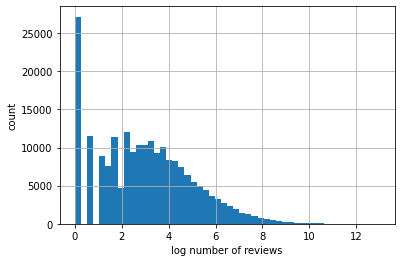

In [9]:
plt.hist(np.log1p(df[['num_reviews']]), bins=50)
plt.xlabel('log number of reviews')
plt.ylabel('count')
plt.grid('on')
plt.show()

To apply our `score_calc` function into our pandas dataframe, I will rewrite below. Here, a `row` parameter is passed, in which now it will take the `row['avg_rating']` and `row['num_reviews']` from each row and apply the `score_calc` function.

In [10]:
def score(row, P=0.1, Q=75):
    """
    Scoring function using a weighted exponential score for 
    the average rating and number of ratings provided by a dataframe.
    
    Parameters
    ----------
    row['avg_rating'] : float
                        Average rating
    row['num_reviews'] : int
                        Number of ratings
    P : float
        Weight assigned to average rating
    Q : float
        Number that defines how much the ratings affect the score
    
    
    Returns
    -------
    float
        a weighted exponential score for the average rating and 
        number of ratings provided.
    """
    p = row['avg_rating']
    q = row['num_reviews']
    
    return P*p + 5*(1-P)*(1-np.exp(-q/Q))

In [11]:
def filter_by_language(df, language='English'):
    """
    Function to filter a dataframe by a language provided.
    
    Parameters
    ----------
    df : dataframe
        Data Frame containing a column named 'language'.
    language : str
        String of the language to filter. 
        Languages can be:
        'English', 'Spanish', 'Turkish', 'Simplified Chinese', 'Arabic',
        'Portuguese', 'Italian', 'Serbian', 'Afrikaans', 'French',
        'Slovak', 'Japanese', 'Hebrew', 'Traditional Chinese', 'Estonian',
        'German', 'Russian', 'Finnish', 'Dutch', 'Hungarian', 'Swedish',
        'Norwegian', 'Thai', 'Bulgarian', 'Polish', 'Urdu', 'Croatian',
        'Marathi', 'Danish', 'Greek', 'Hindi', 'Indonesian', 'Azeri',
        'Vietnamese', 'Bengali', 'Persian', 'Malay', 'Korean', 'Filipino',
        'Romanian', 'Catalan', 'Czech', 'Albanian', 'Telugu', 'Latvian',
        'Ukrainian', 'Tamil', 'Somali', 'Burmese', 'Kazakh', 'Tatar',
        'Kurdish', 'Aymara', 'Malayalam', 'Uzbek', 'Georgian',
        'Lithuanian', 'Gujarati', 'Pashto', 'Haitian', 'Nepali',
        'Armenian', 'Punjabi', 'Swahili', 'Mongolian', 'Slovenian', 'Zulu',
        'Kannada', 'Guaraní', 'Quechua', 'Macedonian', 'Khmer', 'Frisian',
        'Welsh', 'Irish', 'Basque', 'Xhosa', 'Tajik', 'Faroese'
    
    
    Returns
    -------
    dataframe
        a dataframe with the filtered language provided.
    """
    return df[df['language']==language].copy()

## 1.3 Apply Model
In this part I will apply the *hard* and *extreme* models. The idea behind this implementations are:
 - the *hard* model describes the rating of a course on a minimum number of reviews.
 - the *extreme* model describes what the majority of people think on a course.

### 1.3.1 Hard Model
I will apply the hard model on the `English` and `Spanish` courses using a `Q=75`

In [12]:
df_eng = filter_by_language(df, language='English')
df_eng['score'] = df.apply(score, axis=1, args=(0.1, 75))
df_eng.sort_values('score', ascending=False).head(10)

,id,title,avg_rating,num_reviews,language,score
16139,787672.0,Sounds True Presents: The Yoga of Awakening,5.000000,2446.0,English,5.000000
27089,1219774.0,How To Master The Law of Attraction- Abundance,5.000000,741.0,English,4.999770
31437,1343784.0,Paul: A Biography,5.000000,735.0,English,4.999750
16942,819676.0,Draw Islamic Geometric Patterns With A Compass...,5.000000,725.0,English,4.999715
47254,1798036.0,Part 1 FAA Private Pilot Ground School (Part 61),5.000000,652.0,English,4.999245
26216,1191454.0,Master .NET and C# Unit Testing with NUnit and...,5.000000,636.0,English,4.999066
7881,437148.0,Phase 2 - Becoming A Natural Singer,5.000000,573.0,English,4.997836
19290,914070.0,How to get Paid to Travel The World in 2022,5.000000,560.0,English,4.997427
28112,1253204.0,Psychic Readings Intermediate: Angel Cards& Gu...,4.968750,634.0,English,4.995916
28671,1271098.0,Photography - Canon EOS 1300D / REBEL T6 Camer...,4.970588,601.0,English,4.995569


In [13]:
df_sp = filter_by_language(df, language='Spanish')
df_sp['score'] = df.apply(score, axis=1, args=(0.1, 75))
df_sp.sort_values('score', ascending=False).head(10)

,id,title,avg_rating,num_reviews,language,score
41475,1635592.0,Abdomen Definido y Fuerte - Buff Academy,5.000000,1466.0,Spanish,5.000000
2272,115234.0,Dominando WordPress sin programación,4.950000,2125.0,Spanish,4.995000
87192,2851496.0,Flutter Intermedio: Diseños profesionales y an...,4.942748,1863.0,Spanish,4.994275
199705,4756420.0,Nest: Desarrollo backend escalable con Node,4.910088,919.0,Spanish,4.990987
181576,4510678.0,Next.js: El framework de React para producción,4.906780,1253.0,Spanish,4.990678
15931,779476.0,Marketing Jurídico: Alcanza el éxito como abogado,4.900000,1909.0,Spanish,4.990000
37638,1524862.0,Bootstrap 4 !De 0 a Experto! Curso completo + ...,4.900000,1318.0,Spanish,4.990000
56430,2072442.0,Equilibrio Ácido-Base y Gasometría arterial,4.900000,938.0,Spanish,4.989983
4077,241844.0,iOS 9 y Swift 2 | Curso Completo y Desde Cero,4.900000,898.0,Spanish,4.989972
52797,1961104.0,Plataformas Virtuales de Aprendizaje con Googl...,4.900000,867.0,Spanish,4.989957


### 1.3.2 Extreme Model
I will apply the extreme model on the `English` and `Spanish` courses using a `Q=10000`

In [14]:
df_eng = filter_by_language(df, language='English')
df_eng['score'] = df.apply(score, axis=1, args=(0.1, 10000))
df_eng.sort_values('score', ascending=False).head(10)

,id,title,avg_rating,num_reviews,language,score
46631,1778502.0,iOS & Swift - The Complete iOS App Development...,4.788214,79180.0,English,4.977183
98405,3142166.0,[NEW] Ultimate AWS Certified Cloud Practitione...,4.758728,111265.0,English,4.975807
17800,851712.0,The Complete JavaScript Course 2022: From Zero...,4.745153,153232.0,English,4.974514
7886,437398.0,Build Responsive Real-World Websites with HTML...,4.723373,83500.0,English,4.971274
60269,2196488.0,Ultimate AWS Certified Solutions Architect Ass...,4.712643,147510.0,English,4.971263
12120,625204.0,The Web Developer Bootcamp 2022,4.708899,246624.0,English,4.970890
84101,2776760.0,100 Days of Code: The Complete Python Pro Boot...,4.707315,143235.0,English,4.970729
4333,258316.0,Complete C# Unity Game Developer 2D,4.705213,95645.0,English,4.970205
39113,1565838.0,The Complete 2022 Web Development Bootcamp,4.698089,228108.0,English,4.969809
16288,793796.0,Microsoft Excel - Excel from Beginner to Advanced,4.689838,332598.0,English,4.968984


In [15]:
df_sp = filter_by_language(df, language='Spanish')
df_sp['score'] = df.apply(score, axis=1, args=(0.1, 10000))
df_sp.sort_values('score', ascending=False).head(10)

,id,title,avg_rating,num_reviews,language,score
31304,1341936.0,Excel Completo - Desde Principiante Hasta Avan...,4.665037,46164.0,Spanish,4.922006
20980,980450.0,"Desarrollo Web Completo con HTML5, CSS3, JS AJ...",4.683058,40482.0,Spanish,4.889764
28522,1265942.0,Universidad Java - De Cero a Experto - Más Com...,4.672376,35678.0,Spanish,4.840257
23226,1075334.0,Angular: De cero a experto (Legacy),4.648000,25741.0,Spanish,4.621799
12831,649070.0,Lógica Programación: Aprende Programar en Cual...,4.456473,25986.0,Spanish,4.610948
31151,1337000.0,"Master en JavaScript: Aprender JS, jQuery, Ang...",4.510714,22585.0,Spanish,4.480789
62310,2259510.0,Visual Studio Code: Mejora tu velocidad para c...,4.808343,21248.0,Spanish,4.443278
42089,1651564.0,Programación para principiantes - Primeros pasos,4.799869,21091.0,Spanish,4.433925
18539,882422.0,Curso Maestro de Python: De Cero a Programador...,4.699814,21164.0,Spanish,4.427891
59709,2178672.0,Curso Power BI – Análisis de Datos y Business ...,4.689636,20472.0,Spanish,4.388032


## 1.4 Conclusion
From the results we can see that most of the highly rated courses are related to software development skills, but if you want to start a course in a different niche, a good idea will be to start a self-improvement course like a yoga or fitness related one.